<a href="https://colab.research.google.com/github/disney-snoopy/SmArtGenerative/blob/master/notebooks/style_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Import

In [ ]:
#Adding new search path
import sys
sys.path.append('/content/drive/MyDrive/Lewagon/project/style_transfer/scripts')

In [ ]:
#Basic libraries
import matplotlib.pyplot as plt
import numpy as np

#torch libraries
import torch
from torchvision import models
from torch import nn
from torch import optim
import torch.nn.functional as F

#Custom libraries
import loader
from whitenoise import white_noise
from vgg16_construct import model_construct

In [ ]:
#Autoreload
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [ ]:
#for gpu computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Loading Images

In [ ]:
#path_style = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/starry_night.jpg'
path_content = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/le_wagon.jpg'
path_style = '/content/drive/MyDrive/Lewagon/project/style_transfer/img/turner.png'


In [ ]:
#Loading and transforming pictures
tensor_style = loader.loader(path_style).to(device, torch.float)
tensor_content = loader.loader(path_content).to(device, torch.float)

# Gram matrix

In [ ]:
def gram_mat(img):
  '''
  Given a 4 dimensional image, calculate its gram matrix.
  Gram matrix represents style of an image.
  '''
  a, b, c, d = img.shape
  img = img.view(a*b, c*d)
  gram = torch.mm(img, img.t())
  #Normalise
  return gram.div(a*b*c*d)

In [ ]:
model = model_construct(2).to(device, torch.float)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
fmap = model(tensor_style)

In [ ]:
gram_mat(fmap).shape

torch.Size([64, 64])

# Extracting Gram matrix

In [ ]:
class Extract_content(nn.Module):
  #Extract__nn class returns the feature maps of the first 5 conv layers of vgg16.
  def __init__(self):
    super(Extract_content, self).__init__()
    vgg16 = models.vgg16(pretrained=True).features.eval().to(device, torch.float)
    layers = list(vgg16.children())
    self.conv1 = layers[0]
    self.conv2 = layers[2]
    self.conv3 = layers[5]
    self.conv4 = layers[7]
    self.conv5 = layers[10]
    self.maxpool = layers[4]
  def forward(self, x):
    gram = []
    out = self.conv1(x)
    out = F.relu(out)
    gram.append(gram_mat(out))
    out = self.conv2(out)
    out = F.relu(out)
    gram.append(gram_mat(out))
    out = self.maxpool(out)
    out = self.conv3(out)
    out = F.relu(out)
    gram.append(gram_mat(out))
    out = self.conv4(out)
    out = F.relu(out)
    gram.append(gram_mat(out))
    out = self.maxpool(out)
    out = self.conv5(out)
    out = F.relu(out)
    gram.append(gram_mat(out))
    return gram

In [ ]:
model = Extract_content()
grams = model(tensor_style)

In [ ]:
for gram in grams:
  print(gram.shape)

torch.Size([64, 64])
torch.Size([64, 64])
torch.Size([128, 128])
torch.Size([128, 128])
torch.Size([256, 256])


# Whitenoise image
Whitenoise image is used as a baseline image.

In [ ]:
tensor_noise = white_noise(512)

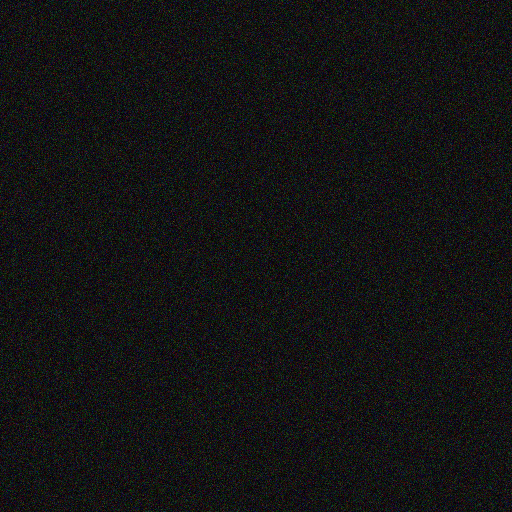

In [ ]:
loader.unloader(tensor_noise)

# Style Reconstruction

In [ ]:
#Layer counts to recreate the model that produced each feature map
layer_counts = [2, 4, 7, 9, 12]

In [ ]:
def style_reconstruct(target_gram, layer_count, img_start = None, imsize = 512, epochs = 50000, lr = 1e5, stop_criterion = 0.995):
  #Deleting computational graph of feature maps.
  target_gram = target_gram.detach()
  #Creating whitenoise image as a starting template
  if img_start == None:
    img_start = white_noise(imsize).to(device, torch.float).requires_grad_()
  #Using MSE loss
  criterion = nn.MSELoss()
  #Using Adam as an optimiser
  opt = optim.Adam(params= [img_start], lr = lr)
  #Instantiating model with given layers from pretrained VGG16
  model = model_construct(layer_count).to(device, torch.float)

  output = []
  stop_loss = 100

  for epoch in range(epochs):
    pred = model(img_start)
    gram = gram_mat(pred)
    loss = criterion(gram, target_gram)

    loss.backward()
    opt.step()
    opt.zero_grad()
    if epoch % 1000 == 0:
      print(f'Epoch {epoch}, Loss: {loss}')
      output.append(img_start.clip(0, 1))
      #if loss/stop_loss > stop_criterion:
       # break
      #stop_loss = loss
      
  return output

In [ ]:
style_recon_1 = style_reconstruct(lr = 1,
                                  target_gram=grams[0], 
                                  layer_count=2,
                                  epochs = 10000)

Epoch 0, Loss: 3.5780477247726594e-08
Epoch 1000, Loss: 2.0248949184065168e-08
Epoch 2000, Loss: 1.878443534053531e-08
Epoch 3000, Loss: 1.761990198190233e-08
Epoch 4000, Loss: 1.654955283925119e-08
Epoch 5000, Loss: 1.5553389687283925e-08
Epoch 6000, Loss: 1.4622784760831564e-08
Epoch 7000, Loss: 1.3751401795047968e-08
Epoch 8000, Loss: 1.293425633264178e-08
Epoch 9000, Loss: 1.2167475915703108e-08


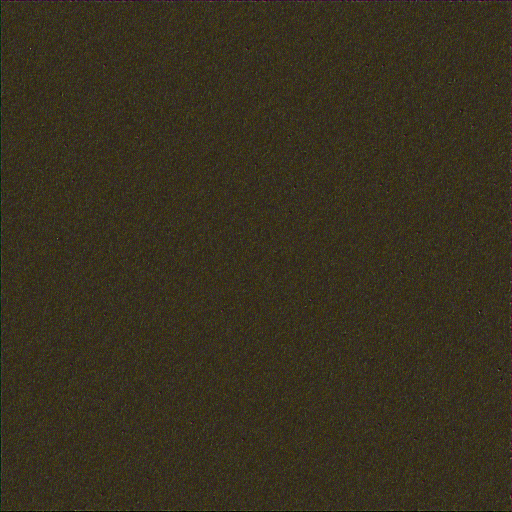

In [ ]:
loader.unloader(style_recon_1[-1])

In [ ]:
style_recon_2 = style_reconstruct(target_gram=grams[1], 
                                  lr = 5,
                                  layer_count=4,
                                  epochs = 50000)

Epoch 0, Loss: 5.03299872889329e-07
Epoch 1000, Loss: 2.2736536209322367e-08
Epoch 2000, Loss: 1.4723254615489623e-08
Epoch 3000, Loss: 9.850913862408106e-09
Epoch 4000, Loss: 6.710815902977174e-09
Epoch 5000, Loss: 4.574571388360482e-09
Epoch 6000, Loss: 3.1124951505034915e-09
Epoch 7000, Loss: 2.1386448167959315e-09
Epoch 8000, Loss: 1.4972194595230803e-09
Epoch 9000, Loss: 1.0702632113890331e-09
Epoch 10000, Loss: 7.831684190051647e-10
Epoch 11000, Loss: 5.879328135449668e-10
Epoch 12000, Loss: 4.515200990873325e-10
Epoch 13000, Loss: 3.538375425993223e-10
Epoch 14000, Loss: 2.824447897786797e-10
Epoch 15000, Loss: 2.2963135559717074e-10
Epoch 16000, Loss: 1.8989274042091608e-10
Epoch 17000, Loss: 1.5952671128527385e-10
Epoch 18000, Loss: 1.3603898563196992e-10
Epoch 19000, Loss: 1.1768155894209542e-10
Epoch 20000, Loss: 1.0310646780808952e-10
Epoch 21000, Loss: 9.139339285368919e-11
Epoch 22000, Loss: 8.183390076688113e-11
Epoch 23000, Loss: 7.391946776902358e-11
Epoch 24000, Loss:

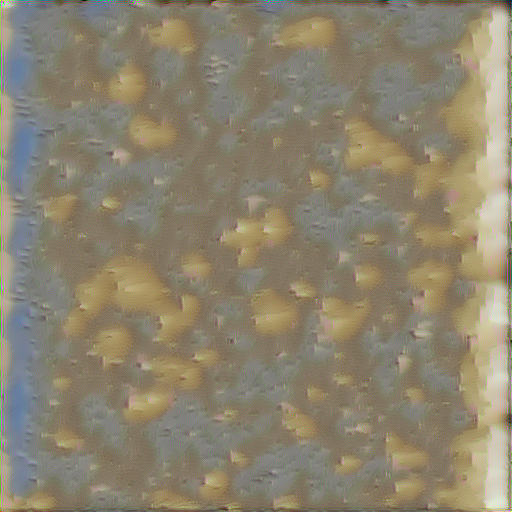

In [ ]:
loader.unloader(style_recon_2[-1])

In [ ]:
len(style_recon_2)

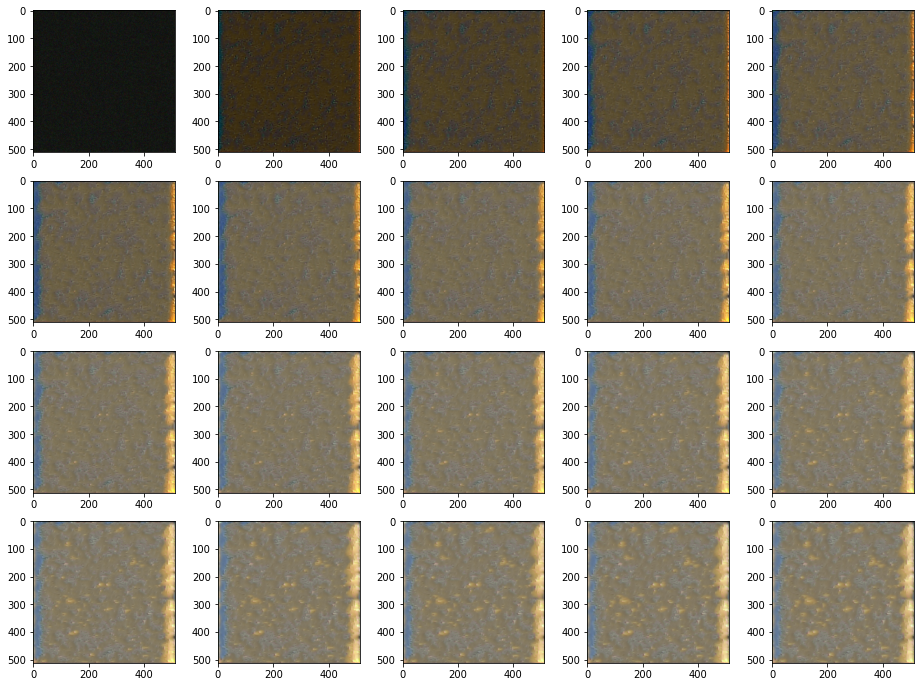

In [ ]:
fig, axs = plt.subplots(4, 5, figsize = (16, 12))
axs = axs.flatten()
for idx, ax in enumerate(axs):
  img = loader.unloader(style_recon_2[idx])
  ax.imshow(img)

In [ ]:
len(style_recon_1)

In [ ]:
fig, axs = plt.subplots(10, 10, figsize = (16, 16), sharex=True, sharey=True)
axs = axs.flatten()
for idx, ax in enumerate(axs):
  img = loader.unloader(style_recon_1[idx])
  ax.imshow(img)